
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

df = pd.read_csv('https://www.dropbox.com/s/6rc0ictd4uj9y27/high_diamond_ranked_10min.csv?dl=1')

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
train = df
test = df.drop('blueWins',axis=1)

In [5]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=df['blueWins'], random_state=42)

In [6]:
target = 'blueWins'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
features = numeric_features

In [7]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [8]:
%%time
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_jobs=1,
        random_state=42,
        max_depth=18,
        min_samples_split=6,
        n_estimators=999
    )
)
pipeline.fit(X_train,y_train)

Wall time: 14.9 s


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=18, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=6,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=999, n_jobs=1,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [9]:
print('training accuracy:', pipeline.score(X_train, y_train))
print('validation accuracy:', pipeline.score(X_val, y_val))

training accuracy: 0.9901303302543338
validation accuracy: 0.7171052631578947


In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [11]:
df.head()

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  

[5 rows x 40 columns]

In [12]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'blueWardsPlaced'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

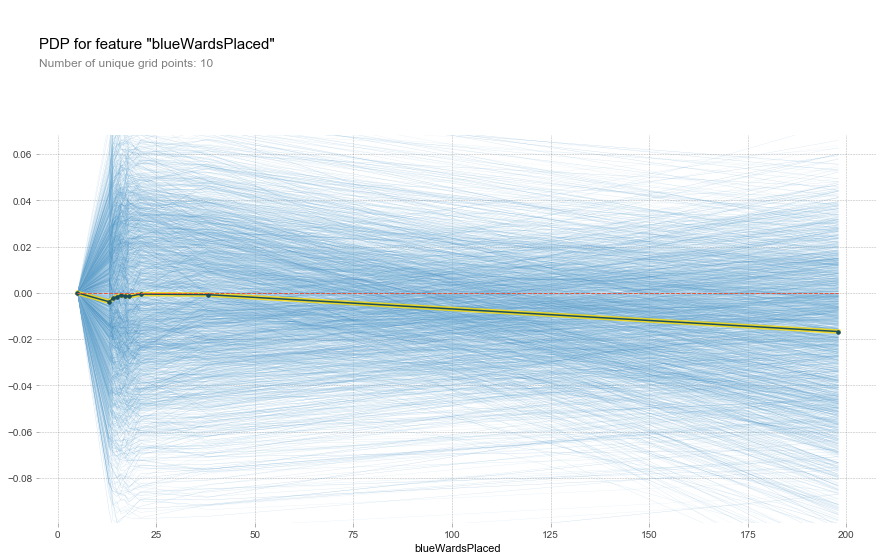

In [13]:
pdp_plot(isolated, feature_name=feature, plot_lines=True);

In [14]:
feature = 'blueKills'

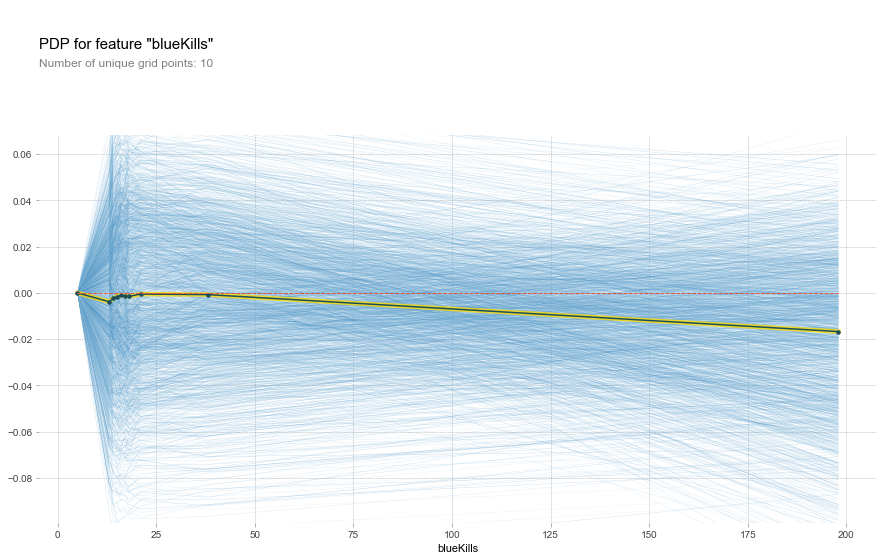

In [15]:
pdp_plot(isolated, feature_name=feature, plot_lines=True);

In [16]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['blueKills', 'redKills']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2508b569bc8>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2508c6dbcc8>})

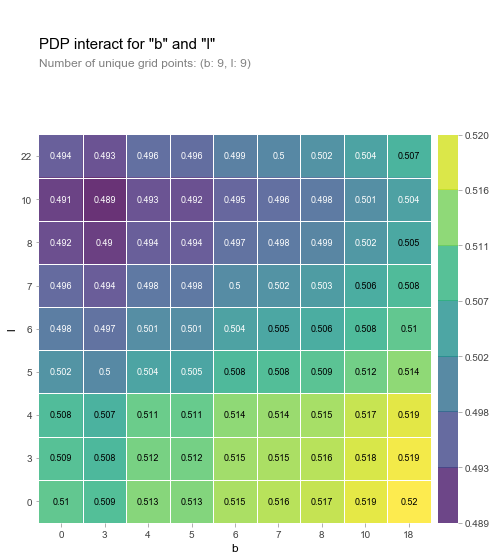

In [17]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)

In [43]:
features = ['blueGoldDiff', 'blueTotalGold', 'redExperienceDiff', 'blueCSPerMin']
X_train = train[features]
# y_train = train[target]
X_test = test[features]
# y_test = test[target]

In [38]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=7, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 7 folds for each of 100 candidates, totalling 700 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 

In [44]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 10, 'max_features': 0.662522284353982, 'n_estimators': 51}
Cross-validation MAE 0.3602828351146313


In [45]:
row = X_test.iloc[[0]]
row

blueGoldDiff  blueTotalGold  redExperienceDiff  blueCSPerMin
0           643          17210                  8          19.5

In [46]:
model.predict(row)

array([0.52402834])

In [47]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)